In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

***Projected Subgradient Method***

In [4]:
def read_data(verbose=False):

    data = pd.read_csv("all_stocks_5yr.csv")
    df = data[["date", "Name", "close"]]

    prices = df.pivot(index="date", columns="Name", values="close")
    prices = prices.dropna(axis=1)

    # with open("prices.txt", "w") as f:
    #     f.write(prices.to_string())
    #     f.close()

    returns = prices.pct_change().dropna()
    # with open("rendements.txt", "w") as f:
    #     f.write(returns.to_string())
    #     f.close()


    X = returns.values
    mu = returns.mean().values
    Sigma = returns.cov().values


    if verbose:
        print("X shape =", X.shape)
        print("mu shape =", mu.shape)
        print("Sigma shape =", Sigma.shape)
    
    return X, mu, Sigma



In [60]:
def projection_on_simplex(v):
    """
    Project a vector v onto the simplex:
        Δ = { w >= 0, sum(w) = 1 }
    """
   
    u = sorted(v, reverse=True)
    cumulative_sum = np.cumsum(u)

    thetas = (cumulative_sum - 1) / (np.arange(1, len(v) + 1))
    k = np.where(u - thetas > 0)[0].max()

    theta = (cumulative_sum[k] - 1) / (k + 1)
    w = np.maximum(v - theta, 0)

    return w

def test(): 
    v = np.array([0.9, 0.9, 0.2])
    v2 = -1 * v

    print("w1 : ", projection_on_simplex(v))
    print("w2 : ", projection_on_simplex(v2))

#test()

def sign(v):
    result = np.zeros_like(v)

    result[v > 0] = 1
    result[v < 0] = -1

    return result


def obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c):

    return 0.5 * w.T @ Sigma @ w -lam * (mu @ w) + \
            c * np.sum(np.abs(w - wprev))

def projected_subgradient_method(lam, c, Sigma, mu, wprev, alpha0=0.1, max_iter=50000, tol= 1e-8, plot=False): 

    w = wprev
    k = 0
    if plot:
        obj_values = []
    for k in tqdm(range(max_iter)):

        if plot:
            obj_values.append(obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c))

        g = Sigma @ w - lam * mu + c * np.sign(w - wprev)
        step_size = alpha0 / (k + 1)
        w_new = projection_on_simplex(w - step_size * g)
        
        if (np.linalg.norm(w_new - w) < tol):
            print(f"Converged in {k} iterations.")
            break

        w = w_new

    with open("values.txt", "w") as f:
        f.write(str(obj_values))
        f.close()


    if plot:
        plt.plot(obj_values)
        plt.xlabel("Iteration")
        
       # plt.yscale("log")
        plt.ylabel("Objective value")
        plt.title("Convergence of Projected Subgradient Method")
        plt.show()
    
    return w




    

X shape = (1258, 470)
mu shape = (470,)
Sigma shape = (470, 470)


 19%|█▊        | 9312/50000 [00:02<00:12, 3228.34it/s]


Converged in 9312 iterations.


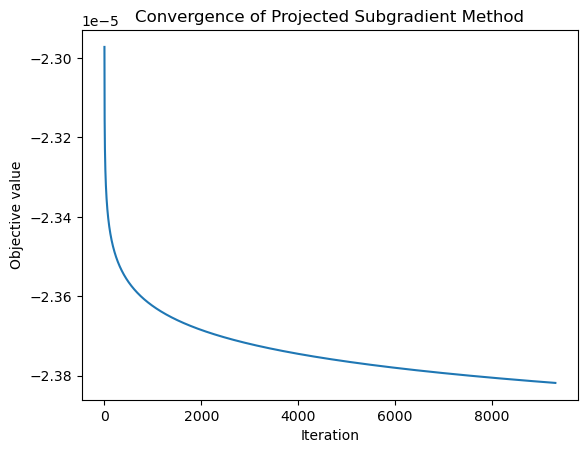

Optimal weights: [0.00210821 0.00217068 0.00212138 0.00216147 0.00217408 0.00215384
 0.00212537 0.00214125 0.00220167 0.00212455 0.00211082 0.00213267
 0.00211457 0.00215057 0.00214655 0.00213907 0.00208063 0.002186
 0.00212788 0.00213945 0.00211151 0.00212627 0.00215228 0.00213238
 0.00212624 0.00212125 0.00223426 0.00215265 0.00215262 0.00209672
 0.00217003 0.00222166 0.00212159 0.00207177 0.00213135 0.00212497
 0.00213982 0.00221763 0.00212766 0.00213736 0.00219012 0.00215693
 0.00216998 0.00201568 0.00203861 0.00212766 0.0021502  0.00213641
 0.00206986 0.00221419 0.0021223  0.00221848 0.00216332 0.00216498
 0.00211859 0.00213719 0.00214788 0.00219841 0.00214003 0.00210593
 0.00212291 0.00221485 0.00216508 0.00204716 0.00214852 0.002132
 0.00212474 0.00212366 0.00213078 0.00213913 0.00218123 0.00209263
 0.00210067 0.00210515 0.00210797 0.00211326 0.00211684 0.00211465
 0.00213105 0.00210611 0.00220184 0.00209782 0.00213604 0.00212766
 0.00216414 0.00212636 0.00211542 0.00208254 0.00

In [61]:
X, mu, Sigma = read_data(verbose=True)
lam = 0.1
c = 0.000001
wprev = np.ones(X.shape[1]) / X.shape[1]

w = projected_subgradient_method(lam, c, Sigma, mu, wprev, tol= 1e-8, plot=True)
print("Optimal weights:", w)
print("Sum of weights:", np.sum(w))
print("Converged objective value:", obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c))

***Proximal gradient method***

In [58]:
def prox(wprev, step_size, v, c):
    return wprev + sign(v - wprev) * np.maximum(np.abs(v - wprev) - c * step_size, 0)


def proximal_gradient_method(lam, c, Sigma, mu, wprev, L, max_iter=50000, tol= 1e-8, plot=False): 

    w = wprev
    step_size = 1/L
    if plot:
        obj_values = []
    for k in tqdm(range(max_iter)):

        if plot:
            obj_values.append(obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c))

        v = w - step_size * (Sigma @ w - lam * mu)
        u = prox(wprev, step_size, v, c)
        w_new = projection_on_simplex(u)
        # if k == 0:
        #     print("norm(v-w):", np.linalg.norm(v - w))
        #     print("c/L:", c / L)
        #     print("max(|v-w|):", np.max(np.abs(v - w)))
        
        if (np.linalg.norm(w_new - w) < tol) and k > -1000:
            print(f"Converged in {k} iterations.")
            break

        w = w_new

    with open("values_proximal.txt", "w") as f:
        f.write(str(obj_values))
        f.close()


    if plot:
        plt.plot(obj_values)
        plt.xlabel("Iteration")
        
        #plt.yscale("log")
        #plt.yscale('symlog', linthresh=1e-3)
        plt.ylabel("Objective value ")
        plt.title("Convergence of Proximal Gradient Method")
        plt.show()
    
    return w

    

 10%|▉         | 4928/50000 [00:01<00:15, 2928.55it/s]

Converged in 4928 iterations.


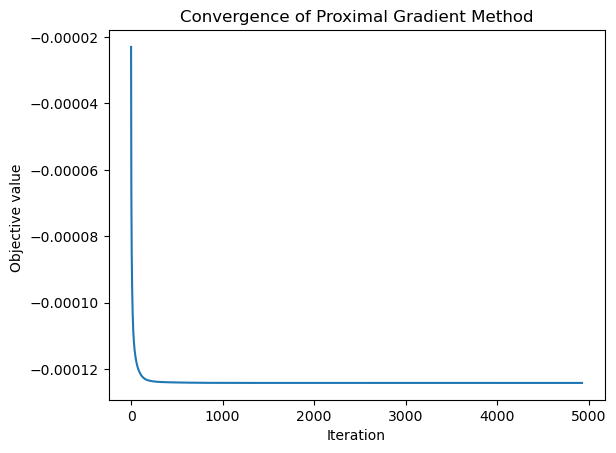

Optimal weights: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.07153961e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.06833041e-02 0.00000000e+00 0.00000000e+00
 0.0000

In [59]:
#X, mu, Sigma = read_data(verbose=True)
lam = 0.1
c = 0.000001
L = np.linalg.eigvalsh(Sigma).max()
wprev = np.ones(X.shape[1]) / X.shape[1]

w = proximal_gradient_method(lam, c, Sigma, mu, wprev, L, max_iter=50000, tol= 1e-8, plot=True) 
print("Optimal weights:", w)
print("Sum of weights:", np.sum(w))
print("Converged objective value:", obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c))

***Long-Step Path-Following Interior-Point method***

In [56]:
def f_mu(w, t, mu_k, Sigma, mu, lam, c, w_prev):
    quad = 0.5 * w @ (Sigma @ w)
    lin  = - lam * (mu @ w)
    l1   = c * np.sum(t)

    f = (quad + lin + l1) / mu_k

    a = t - (w - w_prev)
    b = t + (w - w_prev)

    barrier = - np.sum(np.log(w)) \
              - np.sum(np.log(a)) \
              - np.sum(np.log(b))

    return f + barrier


def grad_f_mu(w, t, mu_k, Sigma, mu, lam, c, w_prev):
    a = t - (w - w_prev)
    b = t + (w - w_prev)

    grad_w = (Sigma @ w - mu * lam) / mu_k \
             - 1.0/w \
             + 1.0/a \
             - 1.0/b

    grad_t = (c / mu_k) * np.ones_like(t) \
             - 1.0/a \
             - 1.0/b

    return np.concatenate([grad_w, grad_t])


def hess_f_mu(w, t, mu_k, Sigma, w_prev):
    n = len(w)

    a = t - (w - w_prev)
    b = t + (w - w_prev)

    H = np.zeros((2*n, 2*n))

    # H_ww
    H_ww = Sigma / mu_k
    H_ww = H_ww + np.diag(1/w**2 + 1/a**2 + 1/b**2)
    H_tt = np.diag(1/a**2 + 1/b**2)
    H_wt = np.diag(-1/a**2 + 1/b**2) 
    
    H = np.block([
        [H_ww, H_wt],
        [H_wt, H_tt]
    ])

    return H

# def delta(w, t, mu_k, Sigma, mu, lam, c, w_prev):
#     g = grad_f_mu(w, t, mu_k, Sigma, mu, lam, c, w_prev)
#     H = hess_f_mu(w, t, mu_k, Sigma, w_prev)
#     v = np.linalg.solve(H, g)
#     return np.sqrt(g @ v)

def delta(w, t, mu_k, Sigma, mu, lam, c, w_prev):

    n = len(w)

    grad = grad_f_mu(w, t, mu_k, Sigma, mu, lam, c, w_prev)

    H = hess_f_mu(w, t, mu_k, Sigma, w_prev)

    A = np.zeros((1, 2*n))
    A[0, :n] = 1.0

    KKT = np.block([
        [H, A.T],
        [A, np.zeros((1,1))]
    ])

    rhs = -np.concatenate([grad, np.zeros(1)])

    sol = np.linalg.solve(KKT, rhs)
    dx = sol[:2*n]

    return np.sqrt(-grad @ dx)


def newton_direction(w, t, mu_k, Sigma, mu, lam, c, w_prev):
    n = len(w)

    g = grad_f_mu(w, t, mu_k, Sigma, mu, lam, c, w_prev)
    H = hess_f_mu(w, t, mu_k, Sigma, w_prev)

    A = np.zeros((1, 2*n))
    A[0, :n] = 1.0

    KKT = np.block([
        [H, A.T],
        [A, np.zeros((1,1))]
    ])

    rhs = -np.concatenate([g, np.zeros(1)])

    sol = np.linalg.solve(KKT, rhs)
    dx = sol[:2*n]

    dw = dx[:n]
    dt = dx[n:]

    return dw, dt


def damped_newton_step(w, t, mu_k, Sigma, mu, lam, c, w_prev):
    dw, dt = newton_direction(w, t, mu_k, Sigma, mu, lam, c, w_prev)
    d = delta(w, t, mu_k, Sigma, mu, lam, c, w_prev)

    alpha = 1.0 / (1.0 + d)

    return w + alpha * dw, t + alpha * dt


def initialization(w_start, t_start, mu_k, tau, Sigma, mu, lam, c, w_prev):

    w = w_start.copy()
    t = t_start.copy()

    d = delta(w, t, mu_k, Sigma, mu, lam, c, w_prev)
    k = 0
    while d >= tau:
        
        w, t = damped_newton_step(w, t, mu_k, Sigma, mu, lam, c, w_prev)
        print(f"Initialization iteration {k}, delta = {d}, w-min = {np.min(w)}, t-min = {np.min(t)}")
        d = delta(w, t, mu_k, Sigma, mu, lam, c, w_prev)
        k += 1

        if k > 500:
            break

    return w, t


def LS_FP_IPM(lam, tau, c, Sigma, mu, wprev, theta,
              nu, max_iter=500, tol=1e-8, plot=False):

    mu_k = 0.01
    n = len(wprev)
    w_start = np.ones(n) / n
    t_start = np.abs(w_start - wprev) + 1.0

    if plot:
        obj_values = []

    print("Initializing...")
    w, t = initialization(w_start, t_start, mu_k, tau, Sigma, mu, lam, c, wprev)
    print("Initialization done.")
    mu_final = tol * (1 - tau) / nu

    k = 1

    while mu_k > mu_final:
        if plot:
            obj_values.append(obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c))

        if k > max_iter:
            print("Maximum iterations reached.")
            break

        while delta(w, t, mu_k, Sigma, mu, lam, c, wprev) >= tau:
            w, t = damped_newton_step(w, t, mu_k, Sigma, mu, lam, c, wprev)
        
        mu_k = (1 - theta) * mu_k
        k += 1
        print(k)
        print(f"mu_k = {mu_k}; mu_final = {mu_final}")

    print(f"Converged in {k} iterations.")

    if plot:
        plt.plot(obj_values)
        plt.xlabel("Iteration")
        
        #plt.yscale("log")
        #plt.yscale('symlog', linthresh=1e-3)
        plt.ylabel("Objective value")
        plt.title("Convergence of Long-Step Path-Following Interior-Point method")
        plt.show()
    return w


Initializing...
Initialization iteration 0, delta = 30.657886463205877, w-min = 0.002127656850767491, t-min = 1.0315861262931176
Initialization iteration 1, delta = 30.657838042549784, w-min = 0.002127654213101865, t-min = 1.0641699343349014
Initialization iteration 2, delta = 30.65778809247908, w-min = 0.0021276516587535963, t-min = 1.0977829368714003
Initialization iteration 3, delta = 30.657736564685518, w-min = 0.0021276491850909084, t-min = 1.1324576420026287
Initialization iteration 4, delta = 30.65768340933495, w-min = 0.0021276467895651485, t-min = 1.1682275846211454
Initialization iteration 5, delta = 30.657628575019245, w-min = 0.0021276444697081623, t-min = 1.2051273588436042
Initialization iteration 6, delta = 30.65757200870648, w-min = 0.002127642223129754, t-min = 1.243192651466634
Initialization iteration 7, delta = 30.65751365568968, w-min = 0.002127640047515224, t-min = 1.282460276479402
Initialization iteration 8, delta = 30.657453459533986, w-min = 0.0021276379406229

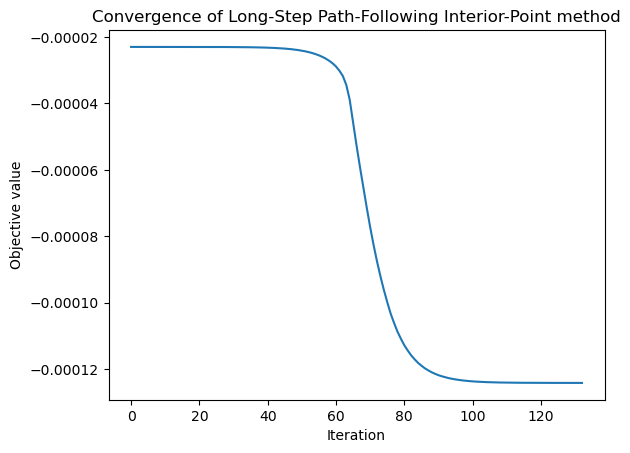

Optimal weights: [4.83391324e-08 1.39380593e-07 6.82749884e-08 8.72841588e-08
 1.59528662e-07 1.10121707e-07 6.33966663e-08 7.61335296e-08
 3.09313487e-07 4.97582056e-08 6.11019435e-08 6.93696530e-08
 5.60161922e-08 7.68136513e-08 9.53659645e-08 8.29547202e-08
 4.33625454e-08 3.58582749e-07 7.03032212e-08 7.94891071e-08
 5.38414304e-08 6.32871351e-08 1.15404839e-07 7.29304083e-08
 5.63897796e-08 5.52141417e-08 7.04947243e-02 9.17208943e-08
 1.17234956e-07 4.80391254e-08 9.04277177e-08 3.67833248e-07
 6.31289754e-08 3.94921824e-08 6.96832432e-08 6.79275560e-08
 7.55843147e-08 1.39324099e-06 6.77532974e-08 6.71606895e-08
 4.05442855e-07 1.23704944e-07 1.44444402e-07 3.06912149e-08
 3.58349140e-08 6.65935653e-08 8.48996754e-08 8.10761571e-08
 3.89620853e-08 3.81833269e-07 6.17519801e-08 5.23572454e-07
 1.23243739e-07 1.49591801e-07 5.81420464e-08 8.82766053e-08
 9.78719826e-08 1.28490832e-06 8.94465186e-08 4.87223198e-08
 6.59425184e-08 4.04715943e-02 1.23825577e-07 3.34881337e-08
 9.4609

In [57]:
#X, mu, Sigma = read_data(verbose=True)
lam = 0.1
c = 0.000001
wprev = np.ones(X.shape[1]) / X.shape[1]
tau = 0.35
theta = 0.15
nu = 3*len(wprev)

w = LS_FP_IPM(lam, tau, c, Sigma, mu, wprev, theta, nu, max_iter=500, tol= 1e-8, plot=True) 
print("Optimal weights:", w)
print("Sum of weights:", np.sum(w))
print("Converged objective value:", obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c))

In [53]:
print(w)

[4.83391324e-08 1.39380593e-07 6.82749884e-08 8.72841588e-08
 1.59528662e-07 1.10121707e-07 6.33966663e-08 7.61335296e-08
 3.09313487e-07 4.97582056e-08 6.11019435e-08 6.93696530e-08
 5.60161922e-08 7.68136513e-08 9.53659645e-08 8.29547202e-08
 4.33625454e-08 3.58582749e-07 7.03032212e-08 7.94891071e-08
 5.38414304e-08 6.32871351e-08 1.15404839e-07 7.29304083e-08
 5.63897796e-08 5.52141417e-08 7.04947243e-02 9.17208943e-08
 1.17234956e-07 4.80391254e-08 9.04277177e-08 3.67833248e-07
 6.31289754e-08 3.94921824e-08 6.96832432e-08 6.79275560e-08
 7.55843147e-08 1.39324099e-06 6.77532974e-08 6.71606895e-08
 4.05442855e-07 1.23704944e-07 1.44444402e-07 3.06912149e-08
 3.58349140e-08 6.65935653e-08 8.48996754e-08 8.10761571e-08
 3.89620853e-08 3.81833269e-07 6.17519801e-08 5.23572454e-07
 1.23243739e-07 1.49591801e-07 5.81420464e-08 8.82766053e-08
 9.78719826e-08 1.28490832e-06 8.94465186e-08 4.87223198e-08
 6.59425184e-08 4.04715943e-02 1.23825577e-07 3.34881337e-08
 9.46096812e-08 6.837435